## Running `tractor` on the ladybug sample
### Updated as of 4/28/2021

In [2]:
# import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output

# Reconstruct data
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

# rubberband
from rubberband.rubberband.tractor.rubber_utils import rubber_tractor_hsc_sep


In [3]:
from tractor import PixelizedPSF
#from kuaizi.tractor.utils import tractor_iteration

In [4]:
# load catalog and images
obj_cat = Table.read('/home/diana/Research/ladybug_tractor/ladybug/ladybug-2021-03-03.fits')

In [5]:
#obj_cat['name']

In [6]:
from kuaizi.tractor.utils import tractor_hsc_sep

# initial channel
channel = 'i'

# channels to do forced photometry
forced_channels = 'grzy'

# all channels
all_channels = 'grizy'

# save all the files to './output'
import os
#os.chdir('./output')
os.getcwd()

'/home/diana/Research/real_tractor'

In [7]:
# changed to be a function rather than loop 
def forcedPhotometry(obj, channel, forced_channels, all_channels):
    '''
    Performs forced photometry using the channel specified. 
    
    Parameters
    
    ``````````
    obj: `astropy.table.row.Row` object
        row pertaining to cutout image
    channel: str
        channel used to initialize tractor (ie, 'i')
    forced_channels: str
        channels to perform forced photometry over (ie, 'grzy')
    all_channels: str
        all channels, including the initial channel (ie, 'grizy')
        
    Returns
    
    `````````
    model_dict: dict of tractor objects
    
    '''
    
    
    obj_name = obj['name'].rstrip('_y')
    obj_id = obj_name.lstrip('ladybug_')
    
    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    cutout = [
        fits.open(
            f'/home/diana/Research/ladybug_tractor/ladybug/1/{obj_id}/hsc/ladybug_{obj_id}_{filt}.fits'
        ) for filt in all_channels
    ]
    psf_list = [
        fits.open(
            f'/home/diana/Research/ladybug_tractor/ladybug/1/{obj_id}/hsc/ladybug_{obj_id}_{filt}_psf.fits'
        ) for filt in all_channels
    ]

    images = np.array([hdu[1].data for hdu in cutout])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    
    # list of channels to perform forced photometry
    forced_filters = list(forced_channels)
    
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
    
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=all_channels)
    # `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy,
    # this includes all channels
    
    # start fitting in the i-band first
    channel = 'i'
    
    model_dict = {}
    model_dict[channel] = tractor_hsc_sep(obj, channel, all_channels, data, 
                                           brick_file='/home/diana/Research/research_downloads/survey-bricks.fits.gz',
                                           freeze_pos=False, verbose=True)
    
    # forced photometry in rest of bands, using modified `tractor_hsc_sep`
    for filt in forced_channels: 
        model_dict[filt] = rubber_tractor_hsc_sep(obj, filt, all_channels, data, 
                                           brick_file='/home/diana/Research/research_downloads/survey-bricks.fits.gz',
                                           freeze_pos=False, freeze_shape = True, freeze_sersic = True, verbose=True)
        
    ### ^ this is where things go wrong! Please see 'rubberband/tractor/rubber_utils.py' (where `rubber_tractor_hsc_sep` is located) ###
        
    # save dictionaries into a pickle
    with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
        pickle.dump(model_dict, f)
        

    return model_dict
    #clear_output()
    #plt.close()

### Where are the modeled parameters stored?

In [ ]:
# acquire position, flux, shape, and sersic index from modeled i-band image
print(model_dict['i'].catalog.subs[0][0]) # pixel position
print(model_dict['i'].catalog.subs[0][1]) # flux
print(model_dict['i'].catalog.subs[0][2]) # shape information
print(model_dict['i'].catalog.subs[0][3]) # sersic index
#model_dict

### Isolate each of these parameters as floats

In [ ]:
#print(model_dict['i'].catalog.subs[0][0]) # pixel position (not truly necessary, since frozen)
print(float(str(model_dict['i'].catalog.subs[0][1]).lstrip('Flux: '))) # flux
print(float(model_dict['i'].catalog.subs[0][2][0])) # re (half-light radius)
print(float(model_dict['i'].catalog.subs[0][2][1])) # e1
print(float(model_dict['i'].catalog.subs[0][2][2])) # e2
print(float(str(model_dict['i'].catalog.subs[0][3]).lstrip('SersicIndex: '))) # sersic index

### Eventually, these parameters will be used to intialize `tractor` in the other bands. 

## Freezing the parameters...

To do this, I created a copy of `kuaizi's` `tractor/utils.py` called `tractor/rubber_utils.py`, which will allow me to pass other parameters to "freeze." In the `rubber` version, `tractor_hsc_sep` is renamed to `rubber_tractor_hsc_sep` to avoid confusion. If everything functions well, I can later replace `tractor_hsc_sep` by `rubber_tractor_hsc_sep` and vary which parameters to freeze. 

### `ladybug_158` i-band
    Detected 20 objects
!!!The file "./tractor-1503p025.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 20
 - Now you have 1 sources
 - Now you have 10 sources


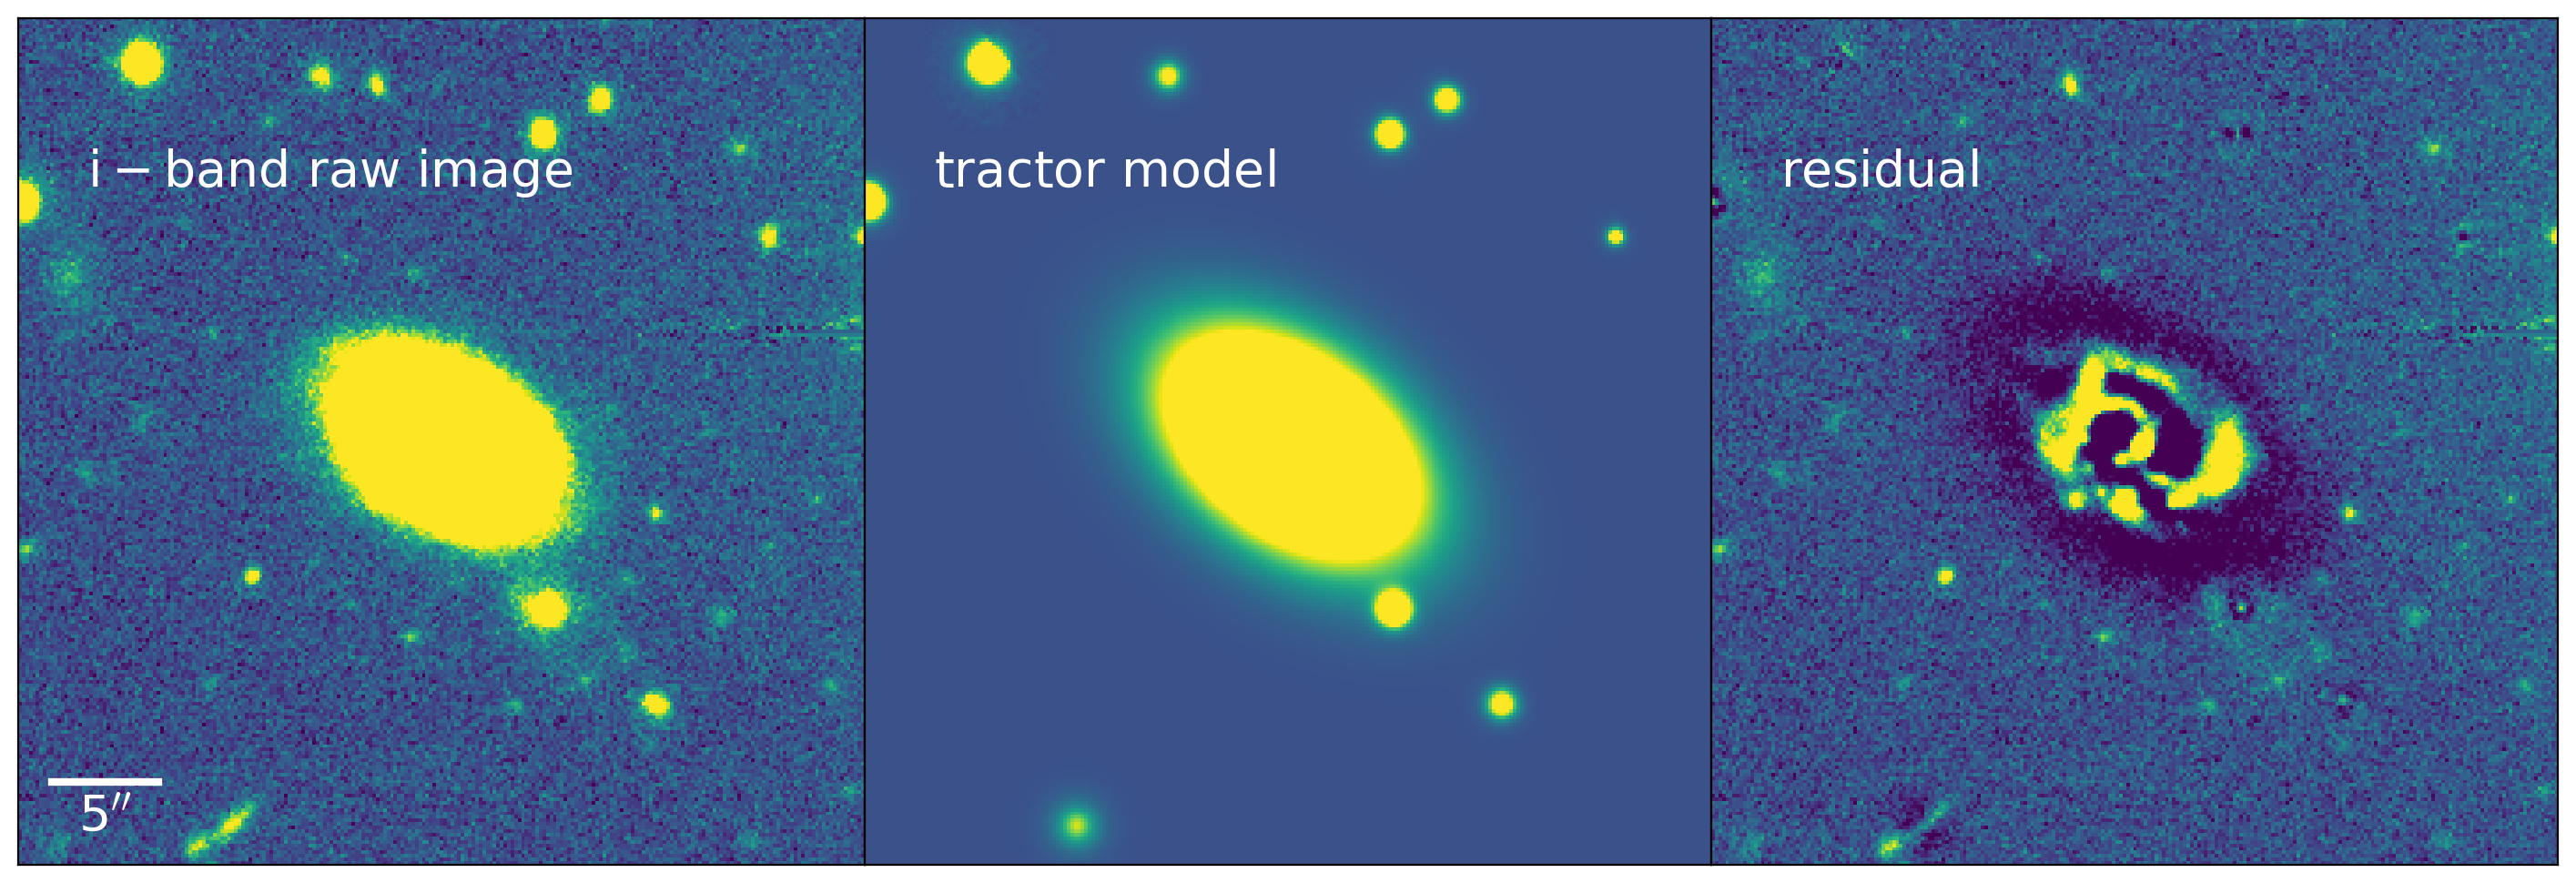

   The chi-square is 1.5920315e-05
 - Now you have 19 sources


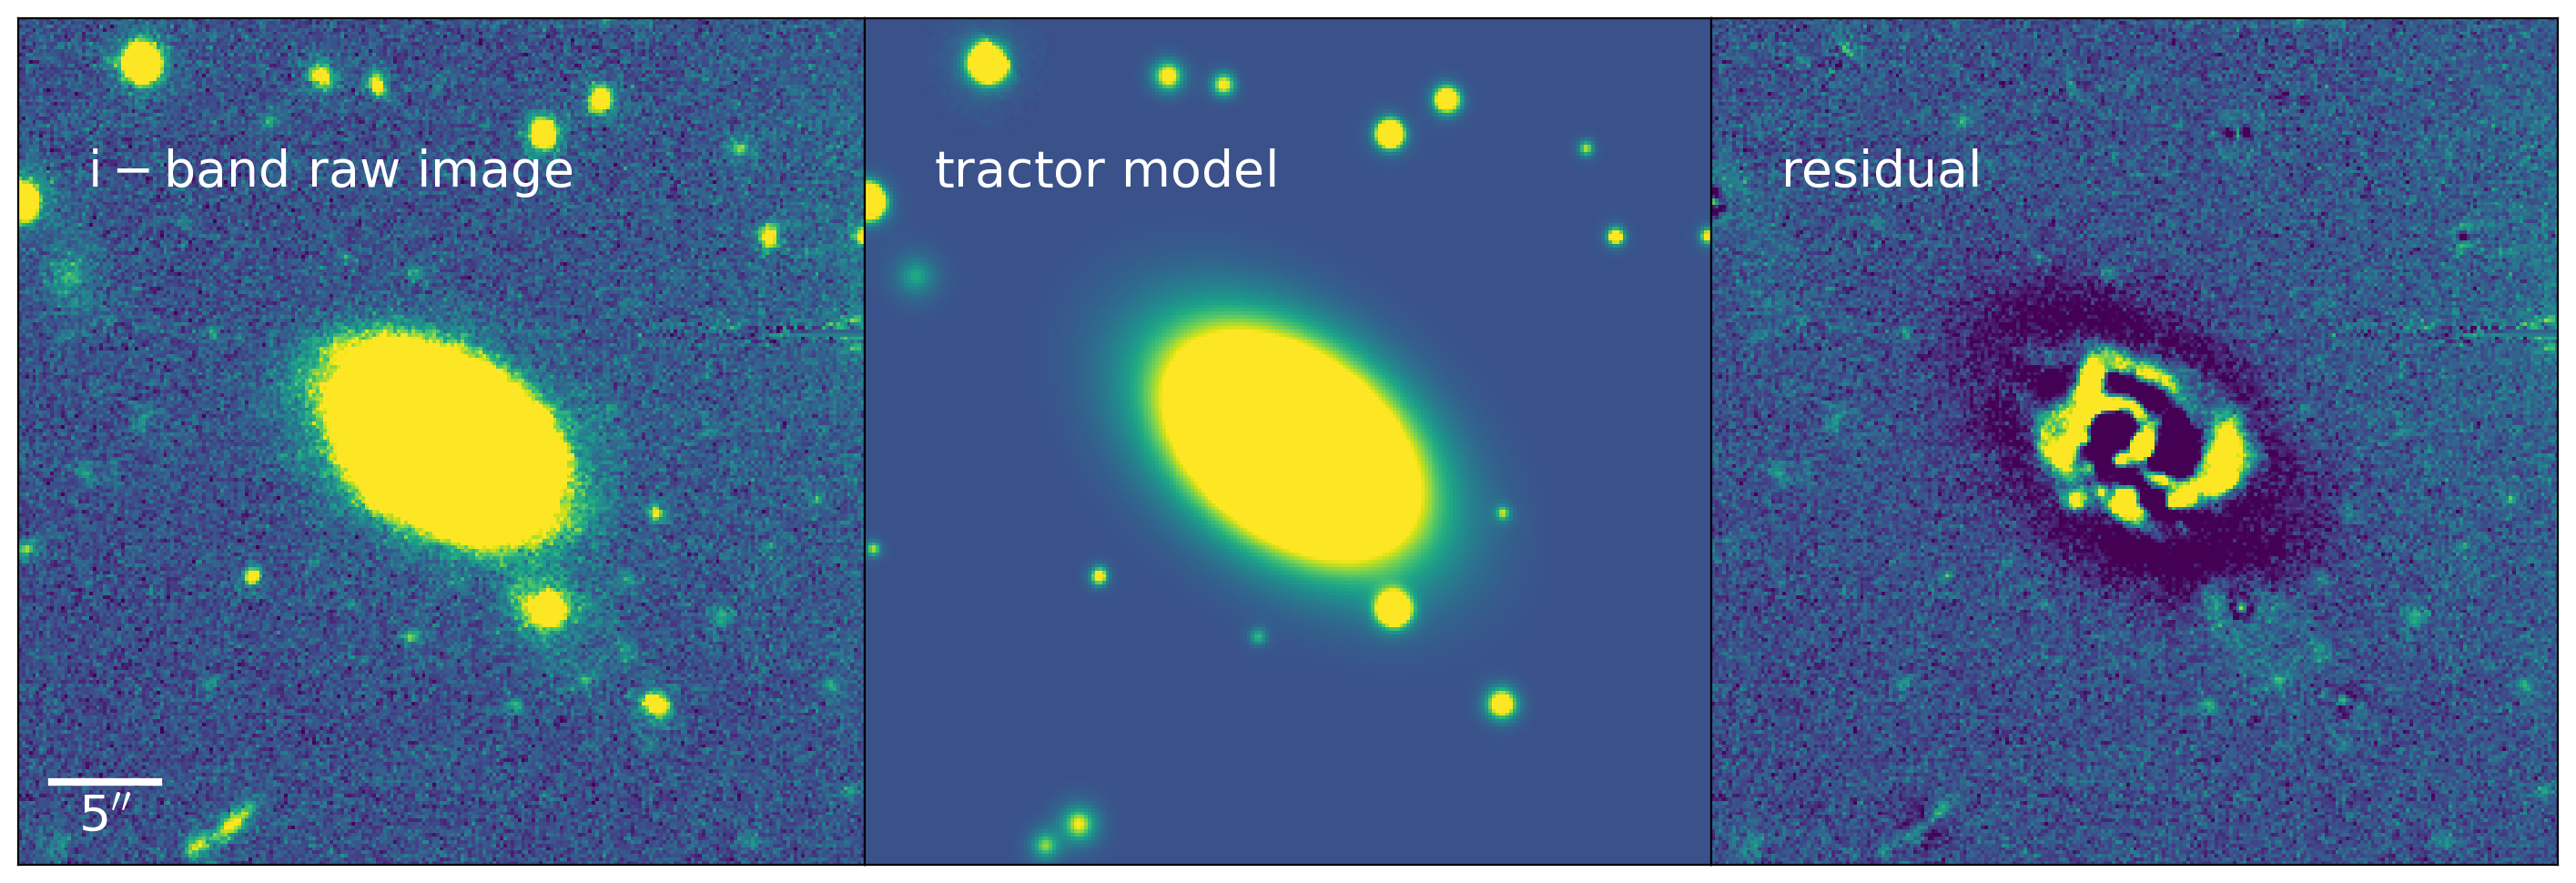

   The chi-square is 1.5753103e-05
### `ladybug_158` g-band
    Detected 11 objects
!!!The file "./tractor-1503p025.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 11
kfold: 
3
 - Now you have 1 sources
Thawed parameters:
   catalog.source0.pos.x = 119.78458129405195
   catalog.source0.pos.y = 118.18121815999807
   catalog.source0.brightness.Flux = 3295.240941200141
 - Now you have 6 sources
   
kfold: 
2
 - Now you have 1 sources
Thawed parameters:
   catalog.source0.pos.x = 119.78458129405195
   catalog.source0.pos.y = 118.18121815999807
   catalog.source0.brightness.Flux = 3295.240941200141
 - Now you have 11 sources
   
kfold: 
1


UnboundLocalError: local variable 'trac_obj' referenced before assignment

In [13]:
model_dict = forcedPhotometry(obj_cat[2], channel, forced_channels, all_channels)

### Parameters shape and sersic index are frozen.
### It looks like trac_obj is never defined in `rubber_tractor_hsc_sep`.